<h1> <a> Data Exploration & Préparation </a> </h1>
<h2> Pour le Challenge Axa </h2>
<h3> Axa Graduate Program Février 2017 </h3>
<i> Author : Paul Tran </i> <br>


----------------------

# Sommaire
1. [Préliminaires](#préliminaires)
    1. [Introduction](#introduction)
    2. [Imports](#imports)
2. [Table de données brute](#brute)
    1. [Chargement des données](#load)
    2. [Description de la donnée](#description)
3. [DataViz](#dataviz)
    1. [Etude des champs](#etude)
        1. [Barplots](#Barplots)
        2. [Pairgrid](#Pairgrid)
        3. [Corrélation](#Corrélation)
    2. [Comparaison des distributions](#comparaison)
4. [Datamagement](#datamanagement)
    1. [Valeurs Manquantes](#missing)
    2. [Encodage disjonctif complet](#dummies)
    3. [Clustering](#kmeans)

--------------------

# Préliminaires <a name="préliminaires"></a>

- ## Introduction :  sujet et objectif <a name="introduction"></a>

Cet exercice est un cas d'étude à réaliser dans le cadre du Graduate Program d'Axa.

Le but de ce challenge est de déterminer l’équation ou l’algorithme permettant d'estimer le bénéfice net annuel attendu pour un client sur son contrat d'assurance automobile.


Nous avons à notre disposition:
- un groupe d'apprentissage de 1 000 observations
- un grupe de test de 300 observations.

Notre étude se décomposera en trois grandes parties (trois notebooks différents):
- data exploration et data handling
- model learning
- fine tuning & tentative d'améliorations

- ## Imports des librairies utiles

In [1]:
import math
import json
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np
from datetime import datetime, date, timedelta
from dateutil.relativedelta import *

#pour la partie data viz
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#import bokeh
#from bokeh.io import output_notebook
#output_notebook()



# I. Table de données brutes <a name="brute"></a>

- ## Chargement des données :<a name="load"></a>

***Dans cette étape, on va fusionner les deux bases de données (celle d'apprentissage et celle de test), afin d'étudier les données dans leur ensemble (nous mettrons en place plusieurs techniques d'apprentissage par la suite, en distinguant bien ces deux bases, pour avoir le modèle le plus performant possible).***

In [2]:
train = pd.read_csv('../data/labeled_dataset.csv', sep = ',', index_col = 'index')
test = pd.read_csv('../data/scoring_dataset.csv', sep = ',', index_col = 'index')

#Merging des bases de train et de test pour étudier les données dans leur ensemble.
data=pd.concat([train,test])
data=data.reset_index().set_index('index')

In [3]:
#Observation de la table
train.head()

,Age,Prime mensuelle,Categorie socio professionnelle,Kilometres parcourus par mois,Coefficient bonus malus,Type de vehicule,Score CRM,Niveau de vie,Marque,Salaire annuel,Score credit,Cout entretien annuel,Benefice net annuel
index,,,,,,,,,,,,,
0,58.0,40.0,Etudiant,973,106,SUV,164,3762,Peugeot,20420,309,801,54.998558
1,26.0,27.0,Ouvrier,637,95,5 portes,126,3445,Renault,25750,135,667,7.840930
2,27.0,26.0,Cadre,978,136,SUV,153,986,Renault,6790,786,696,46.078889
3,22.0,8.0,Etudiant,771,96,3 portes,111,2366,Peugeot,15140,320,765,-11.048213
4,60.0,20.0,Sans emploi,758,101,3 portes,149,1441,Peugeot,12850,287,808,1.180078


- ## Description qualitative des données <a name="description"></a>

Que ce soit pour la base d'apprentissage **"labeled_dataset"** ou la base de test **"scoring_dataset"**, les données contiennent 12 variables dont 10 explicites (code postal, année de naissance, marque du véhicule, profession,...).

L'index est l'identifiant de la ligne, la variable **"Benefice net annuel"** est la variable d'intérêt (ou label) que l'on cherche à estimer.

Remarque : les données fournies sont fictives (valeurs de variables changées, distribution ne reflétant pas la réalité, population, etc...), mais connotent de l'aspect métier de l'entreprise
- > salaire annuel du cadre (index 2) a un salaire de 6 790 v.s. salaire de l'étudiant (index 0) à 20 420, ce qui est possible mais peu probable dans la réalité, surtout pour un échantillon aussi petit.

***Dans ce premier traitement, nous comptons le nombre de valeurs absentes pour chaque variable. Pandas interprète comme des NaN l'absence de valeurs. Énumérons ainsi l'ensemble des NaN pour chaque variable. Nous remarquons que certaines variables sont clairsemées, voire absentes ("Benefice net annuel" a exactement 300 valeurs absentes ; ce qui est  logique puisqu'il s'agit des données à prédire).***

In [4]:
#nombre de NaN par colonnes
data.isnull().sum()

Age                                 22
Benefice net annuel                300
Categorie socio professionnelle      0
Coefficient bonus malus              0
Cout entretien annuel                0
Kilometres parcourus par mois        0
Marque                              69
Niveau de vie                        0
Prime mensuelle                     13
Salaire annuel                       0
Score CRM                            0
Score credit                         0
Type de vehicule                     0
dtype: int64

- > **Interprétation :** le dataset est globalement 'propre' et ne comporte que très peu de données manquantes. Seul un faible nombre de variables sont touchées :
    - l'Age
    - la Marque
    - la Prime mensuelle

***À présent, nous souhaitons connaître les types de chaque variable. À noter que lorsque la variable prend plusieurs types de valeurs, Python nous affiche le type "object". Nous remarquons que les variables numériques sont prédominantes en terme de présence.***

In [5]:
#type des variables
data.dtypes

Age                                float64
Benefice net annuel                float64
Categorie socio professionnelle     object
Coefficient bonus malus              int64
Cout entretien annuel                int64
Kilometres parcourus par mois        int64
Marque                              object
Niveau de vie                        int64
Prime mensuelle                    float64
Salaire annuel                       int64
Score CRM                            int64
Score credit                         int64
Type de vehicule                    object
dtype: object

- > **Interprétation :** à l'aveugle, il est possible de considérer naïvement les variables :
    - de type numérique comme de l'information à valeur quantitative
    - de type objet (ou str) comme de l'informaton à valeur catégorielle
    
    Néanmoins, il est prudent de préter attention aux données numériques qui peuvent tout aussi bien être catégorielles si notamment à valeurs dans un espace discret.

In [6]:
#nombre de valeurs uniques pour les champs :
liste_var=['Age','Benefice net annuel','Coefficient bonus malus','Cout entretien annuel',
        'Kilometres parcourus par mois','Niveau de vie','Prime mensuelle','Salaire annuel',
       'Score CRM', 'Score credit']

for variable in liste_var:
    print('La variable numérique %s prend %s valeurs uniques.' %(variable,len(set(data[variable]))))


La variable numérique Age prend 96 valeurs uniques.
La variable numérique Benefice net annuel prend 1300 valeurs uniques.
La variable numérique Coefficient bonus malus prend 88 valeurs uniques.
La variable numérique Cout entretien annuel prend 405 valeurs uniques.
La variable numérique Kilometres parcourus par mois prend 628 valeurs uniques.
La variable numérique Niveau de vie prend 1186 valeurs uniques.
La variable numérique Prime mensuelle prend 80 valeurs uniques.
La variable numérique Salaire annuel prend 1144 valeurs uniques.
La variable numérique Score CRM prend 109 valeurs uniques.
La variable numérique Score credit prend 723 valeurs uniques.


#### II. Analyses simples des données

- ## Etude descriptive de la donnée <a name="description"></a>

***À présent, faisons de la statistique descriptive basique sur nos donnnées (moyenne, écart-type, quartiles, etc). Nous remarquons que l'individu moyen a 35 ans, parcourt en moyenne 605km, qu'il a un salaire moyen de 30K et dégagerait un bénéfice net annuel de 17 euros.***

- > ***Notez que certaines valeurs sont aberrantes :***
    - ***Age minal de 0 an et maximal de 198 ans, ce qui est improbable***

In [7]:
#Colour style for pandas cells
def highlight_max(data, color='yellow'):
    '''
    highlight the max in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
def highlight_min(data, color='yellow'):
    '''
    highlight the min in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [8]:
#Description de la table
data.describe()[1::].style.apply(highlight_max, color='darkorange', axis=None,subset=['Age'])\
                            .apply(highlight_min, color='darkorange', axis=None,subset=['Age'])

# III. Data visualisation <a name="dataviz"></a>

- ## Etude de certains champs <a name="etude"></a>

***On cherche à visulaliser simplement la distribution de certains champs***

 - -    **Marques & types des véhicules, CSP, Age**  <a name="Barplots"></a>
 
 **On cherche à observer les valeurs les plus courantes**

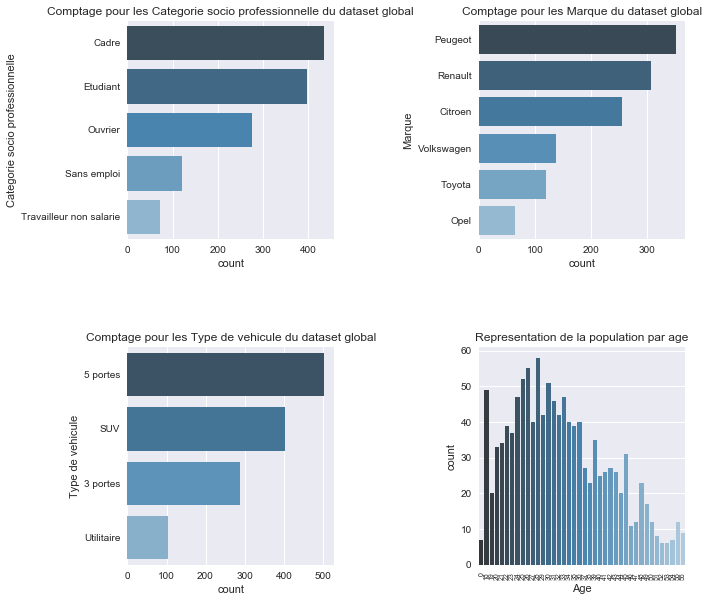

In [9]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2,2, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.7)

axs=axs.ravel()

i=0
liste_champs=['Categorie socio professionnelle','Marque','Type de vehicule']
for champs in liste_champs:
    a=sns.countplot(y=champs,
                   order=data[champs].value_counts().index,data=data,palette='Blues_d',ax=axs[i])
    a.set_title('Comptage pour les %s du dataset global' %(champs))
    i=i+1
    
a = sns.countplot(x="Age", order=data['Age'].value_counts().sort_index().index[0:40],data=data,palette='Blues_d',
                 ax=axs[3])
a.set_title('Representation de la population par age')
l=[int(i) for i in list(data['Age'].value_counts().sort_index().index)]
#a.axes.get_xaxis().set_ticks(l[0:40:2])
a.set_xticklabels(l[0:40])
plt.setp(a.get_xticklabels(), fontsize=7, rotation='vertical')
a

- - ** Zoom sur l'Age**

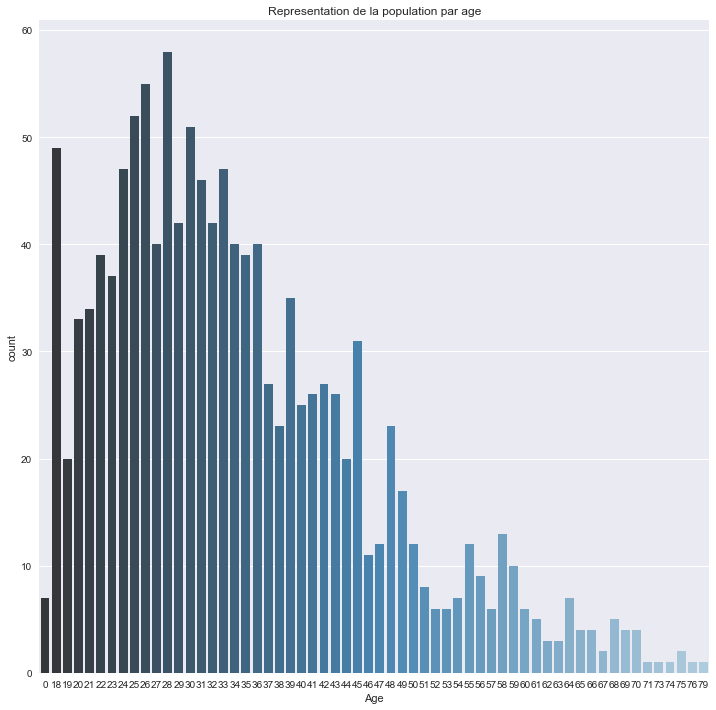

In [10]:
plt.figure(figsize=(12,12))
l=[int(i) for i in list(data['Age'].value_counts().sort_index().index)]
sns.set(style="darkgrid")
ax = sns.countplot(x="Age", order=data['Age'].value_counts().sort_index().index[0:60],data=data,palette='Blues_d')
ax.set_title('Representation de la population par age')
ax.set_xticklabels(l)
ax

- > ** Interprétation : on constate bien que la répartition des âges est quelque peu erratique... Un répartition plus traditionnelle ressemblerait au graphe ci-dessous (issu d'un dataset de pricing de la Maif):**

<img src="../images/distribution_standard_age.png">

- - **Pairgrid relations**  <a name="Pairgrid"></a>

***On cherche à présenter les différentes relations entre variables numériques.***

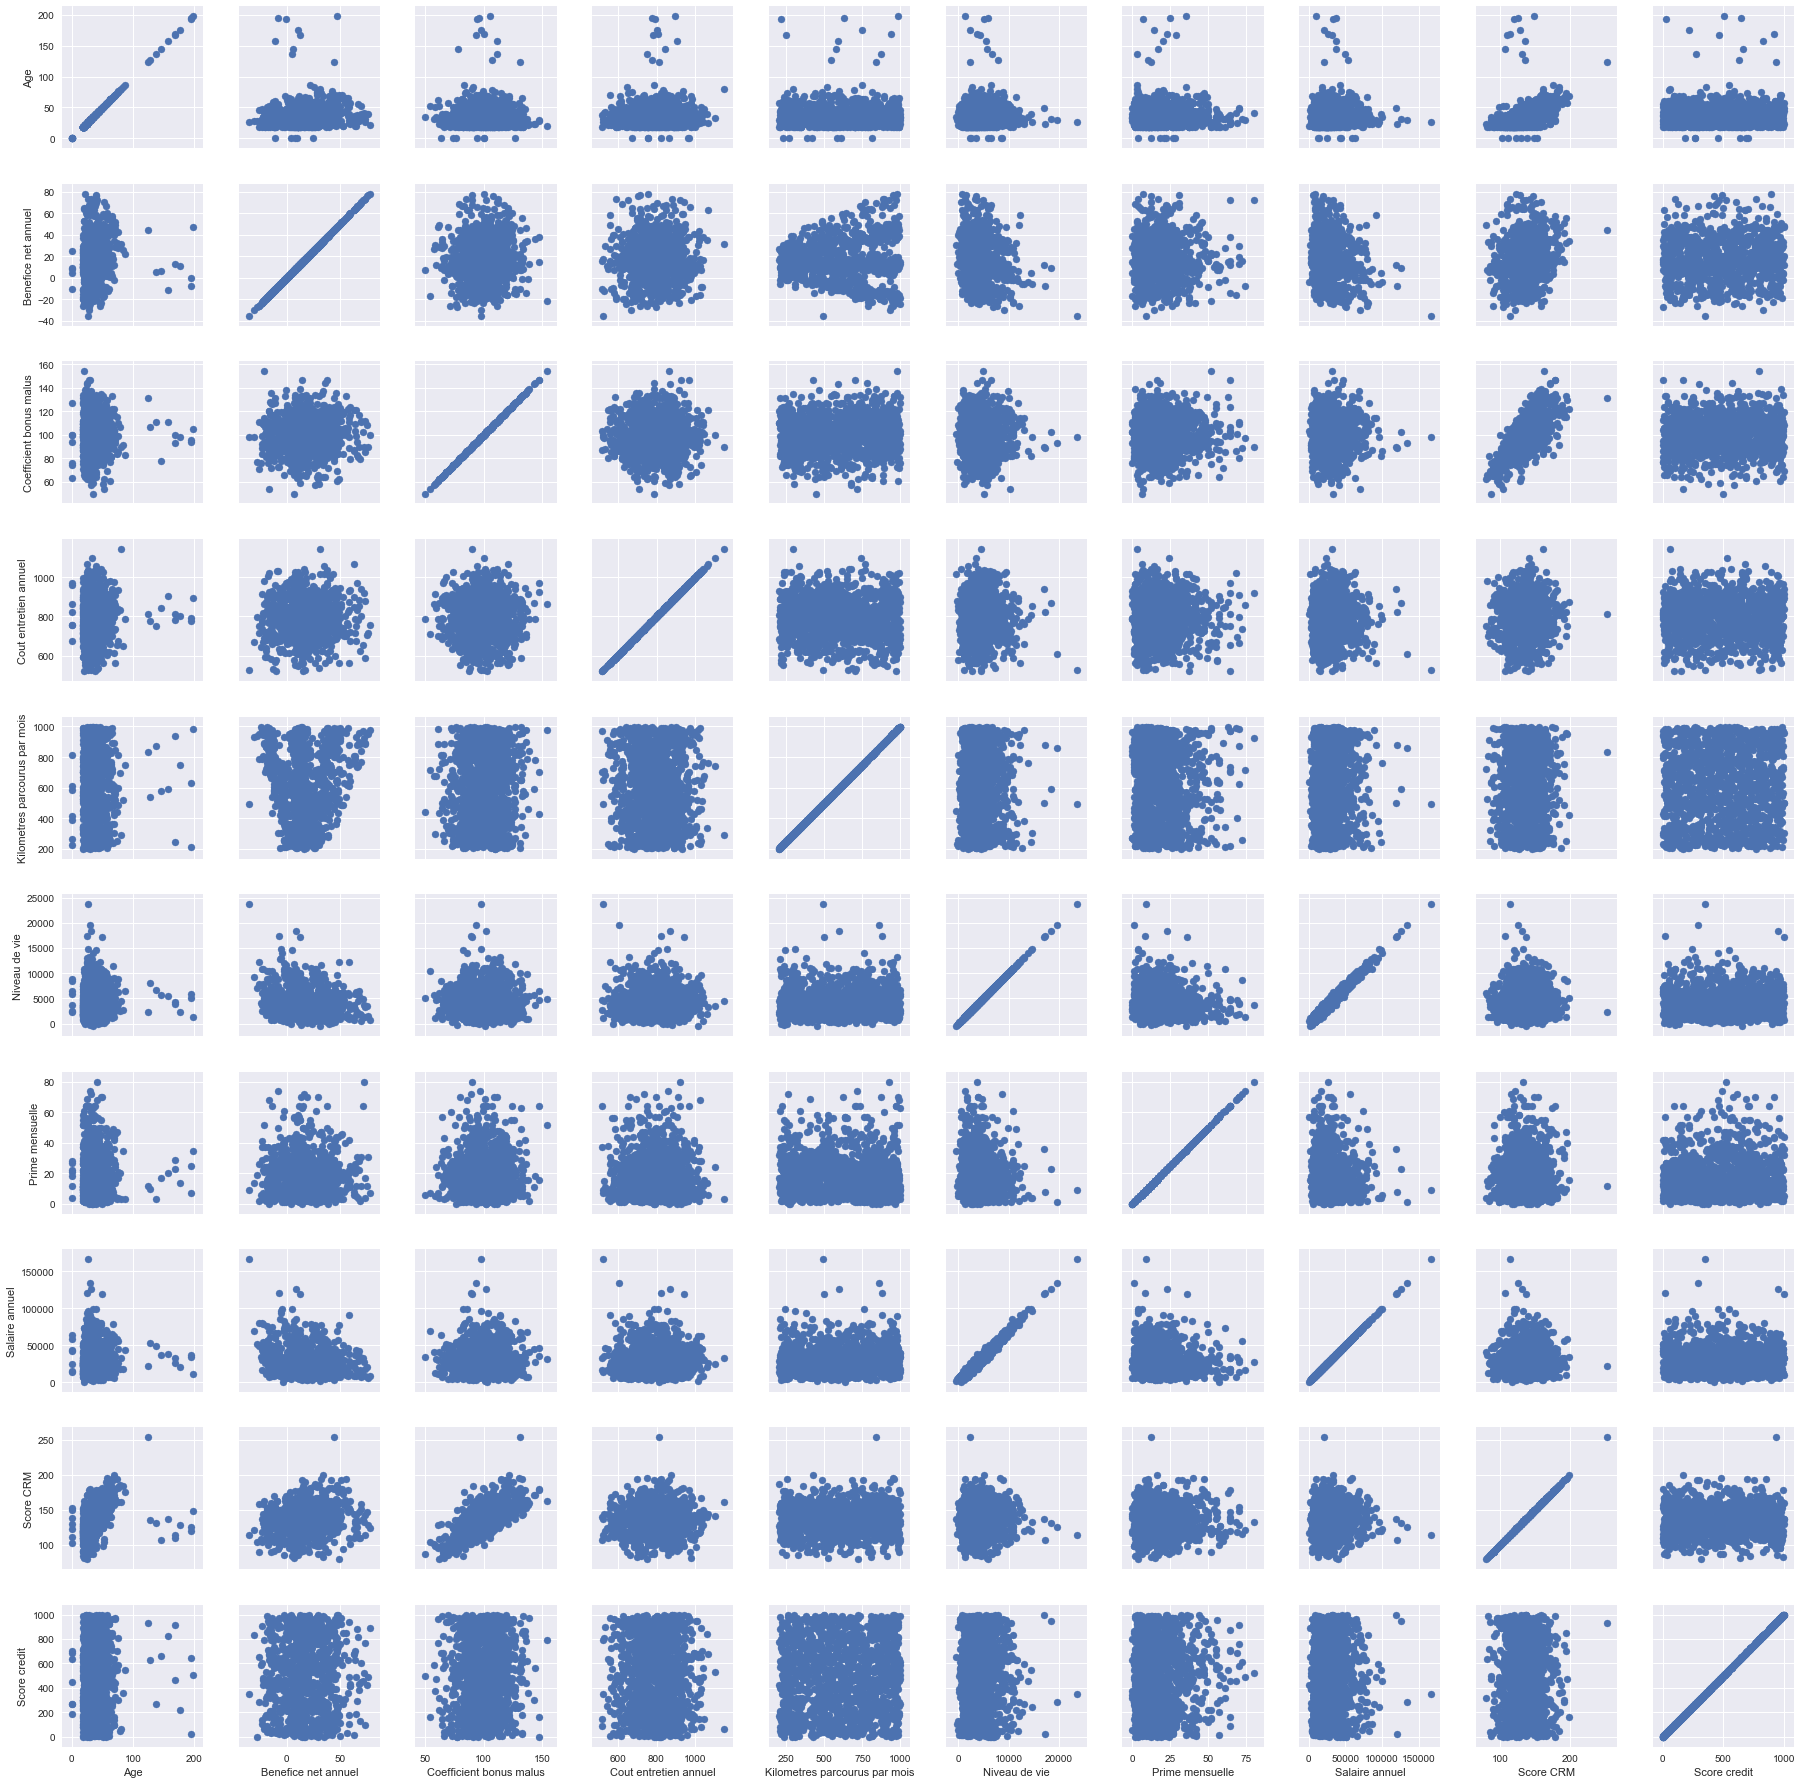

In [11]:
g = sns.PairGrid(data)
g.map(plt.scatter)
#salaire annuel et niveau de vie semblent de relation linéaire

- > ** Interprétation : on constate bien qu'il existe une relation quasi linéaire entre le niveau de vie et le salaire annuel.**

**Néanmoins le graphe est très peu interprétable en tant que tel, nous allons privilégier une autre visualisation : la matrice de corrélation.**

- - **Matrice de corrélation**  <a name="Corrélation"></a>

***De façon plus lisible on cherche à visualiser les corrélations entre variables.***

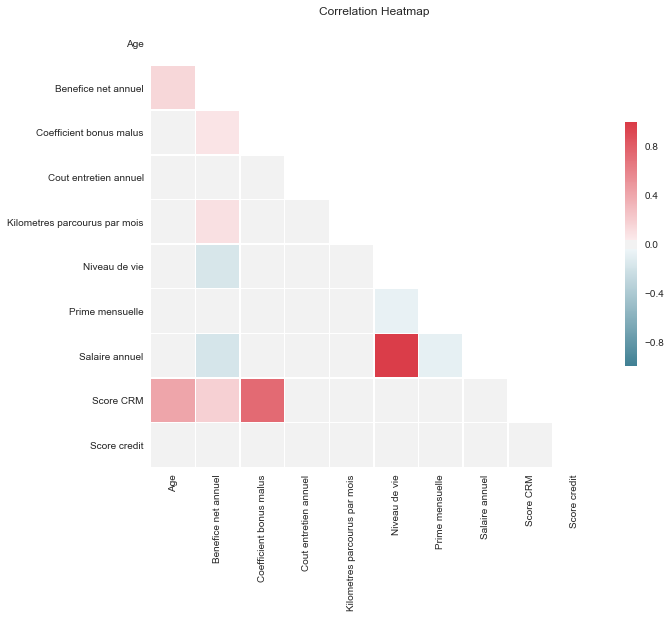

In [12]:
#Calcul de la matrice de corrélation
corr = data.corr()

#Mask pour la partie supérieur de la heatmap
#a à de la symétrie de la matrice
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

#Init
f, ax = plt.subplots(figsize=(10, 9))

#Generer une color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#plot la matrice de correlation
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax)
            #xticklabels=corr.columns, yticklabels=corr.columns,
ax.set_title('Correlation Heatmap')

- > ** Interprétation :**
    - **Très forte corrélation positive entre Salaire annuel et Niveau de vie, ce qui est logique.**
    - **Score CRM corrélé positivement avec l'âge & le coefficient bonus-malus**
    - **La cible à prédire c-à-d le Bénéfice net annuel est modérément corrélé positivement avec l'âge et le score CRM et négativement corrélé avec le niveau de vie et le salaire annuel (puisque ces derniers vont de paire)**
    - **Le score crédit ne semble être corrélé à aucune variable du dataset, ce qui semble étrange car habituellement calculé à partir des variables du client**

**On peut donc comprendre que l'âge et le score CRM sont des facteurs positifs pour le calcul du Bénéfice net mais néanmoins le niveau de vie tend à diminuer le bénéfice réalisé. Cela peut être interprétable par le fait que plus le niveau de vie est élevé plus le véhicule du client est coûteux à assurer du fait de sa montée en gamme.**

- ## Comparaison des distributions des variables entre les datasets Train et Test <a name="comparaison"></a>

***L'objectif de cette sous partie est de s'assurer que les datasets d'apprentissage et de test possèdent des distributions identiques afin que le modèle soit juste.***

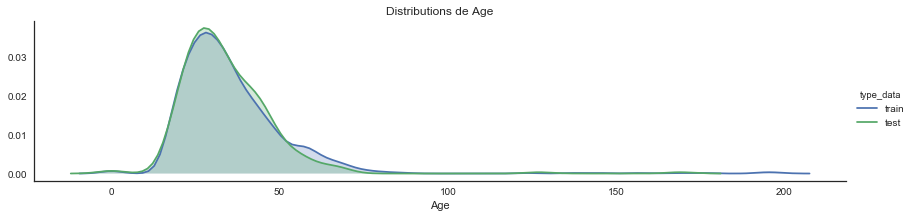

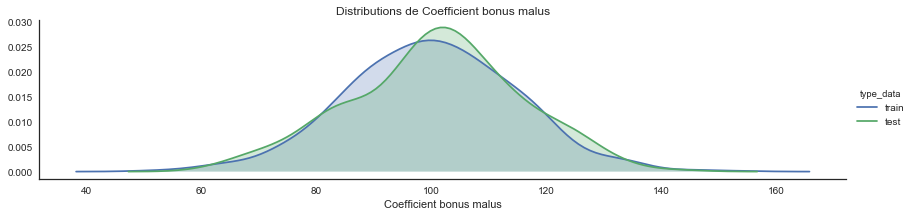

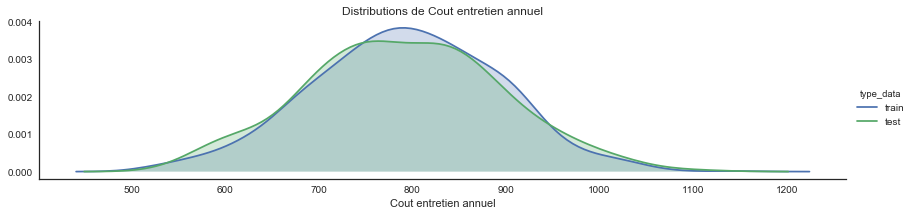

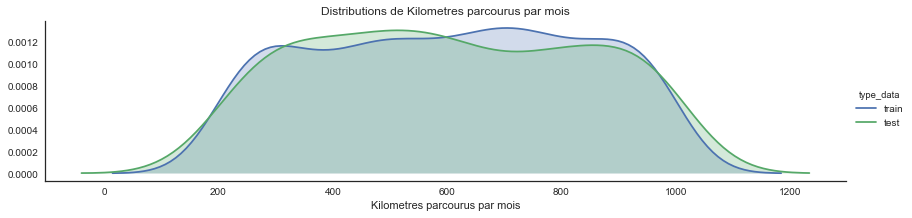

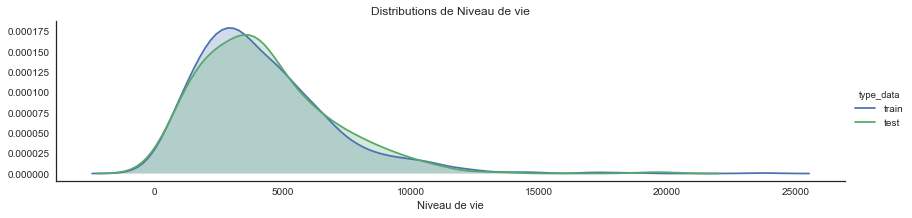

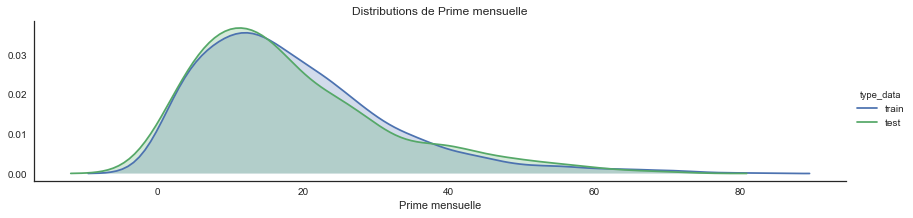

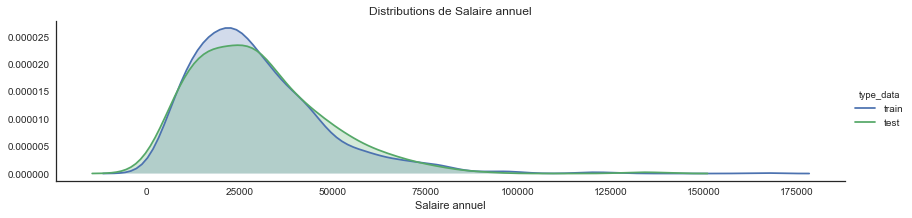

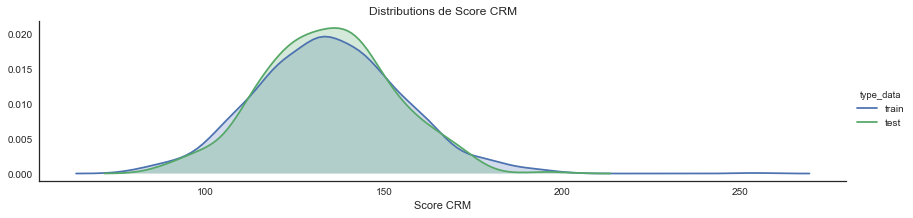

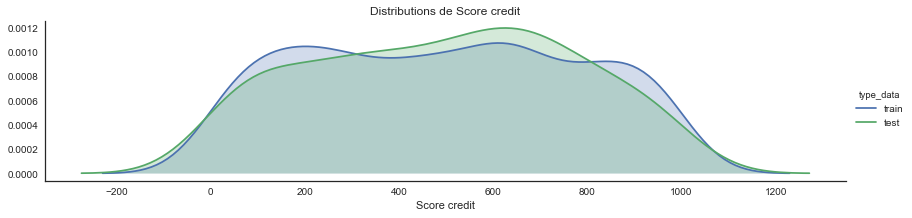

In [13]:
#ajout de la colonne type_data pour différencier les lignes du train set de celles du test set
data['type_data']=['train'] * 1000 + ['test']*300 #car concaténation simple des deux data sets

#liste des variables numériques dont on cherche à observer les distributions
liste_var=['Age','Coefficient bonus malus','Cout entretien annuel',
        'Kilometres parcourus par mois','Niveau de vie','Prime mensuelle','Salaire annuel',
       'Score CRM', 'Score credit']

for var in liste_var:
    #plot des densités
    try:
        facet = sns.FacetGrid(data, hue="type_data",aspect=4) #palette="Blues_d"
        facet.map(sns.kdeplot,var,shade= True)
        plt.title('Distributions de %s' %(var))
        facet.add_legend()
        plt.show()
    except Exception as e:
        print("Error ploting %s à cause de l'erreur : %s" %(var,e))
        
del data['type_data'] #on peut supprimer cette colonne désormais

- > ***Interprétation: les distributions des variables semblent être respectées entre le dataset d'apprentissage et le dataset de test*.**

# IV. Gestion des données manquantes et des variables catégorielles <a name="datamagement"></a>

- ## Gestion des données manquantes : <a name="missing"></a>

***Ici, nous répertorions les variables où des données sont manquantes.***

In [14]:
#Vérifier les colonnes concernées [possédant des NaN]
for element in data.isnull().sum().index:
    if data[element].isnull().sum()!=0:
        print ('La colonne %s comporte une ou plusieurs valeurs nulle.' %element)

La colonne Age comporte une ou plusieurs valeurs nulle.
La colonne Benefice net annuel comporte une ou plusieurs valeurs nulle.
La colonne Marque comporte une ou plusieurs valeurs nulle.
La colonne Prime mensuelle comporte une ou plusieurs valeurs nulle.


- > **Mais comme précisé plus haut, seul Age, Marque et Prime mensuelle nous intéresse. En effant le Bénéfice net annuel est la variable à prédire donc il est normal qu'elle soit manquante.**

***Maintenant que nous savons quelles données sont manquantes, nous mettons en place une première stratégie : nous colmatons ce clairsemage par les valeurs médianes pour les valeurs numériques et la top valeur en terme de comptage pour les variables qualitatives. D'autres stratégies pourront être testées dans la partie Fine-tuning.***

In [15]:
data_raw01=data.copy(deep=True)
%store data_raw01
#Enregistrer la donnée afin de permetrre de la charger dans une autre session jupyter
#Permet la manipulation de données à travers notebooks

Stored 'data_raw01' (DataFrame)


In [16]:
# Première approche : remplacer les valeurs manquantes par la médiane pour les variables quantitatives
    # par la valeur top (de comptage) pour les variables qualitatives
# Travailler sur l'intégralité du dataset (train+test) prend ici tout son sens
for element in data.isnull().sum().index:
    if data[element].isnull().sum()!=0 and data[element].dtype!=np.object:
        data[element] = data[element].fillna(data[element].median())
    if data[element].dtype==np.object:
        data[element]=data[element].fillna(data[element].describe().top) #remplacer par sa valeur top

data_raw02=data.copy(deep=True)       

In [17]:
#Nous stockons cette nouvelle table (intitulée "data_raw"), pour l'utiliser ultérieurement dans un autre Notebook.
%store data_raw02

Stored 'data_raw02' (DataFrame)


- ## Encodage complet disjonctif (dummisation) <a name="dummies"></a>

***Nous constituons une liste des variables dont les valeurs sont de types multiples. Pour rappel, de telles variables sont dites de type "object".***

In [18]:
#Vérifier les colonnes qui sont de type objet
list_categorical=[]
for element in data.columns:
    if data[element].dtype==np.object:
        list_categorical.append(element)
        print('La variable %s est de type Object.' %(element))

La variable Categorie socio professionnelle est de type Object.
La variable Marque est de type Object.
La variable Type de vehicule est de type Object.


***Notre programme nous annonce donc que les variables "var7" et "var16" sont des variables de type "object" (comme ce qui a été vu au début de ce Notebook).***

In [19]:
#Dummisation

"""Attention, l'option drop_first = True permet de ne conserver que les (k-1) modalités, évitant ainsi d'avoir des
colonnes linéairement dépendantes. En effet, il est facile de déterminer la k-ième modalité en fonction des (k-1)
autres.

Cette option a toute son importance dans le calcul de la régression linéaire.

Cette option est inédite dans la version de Pandas 0.18 (elle n'existait pas auparavant)."""

data = pd.get_dummies(data, columns=list_categorical,drop_first=True)
data.shape

(1300, 22)

In [20]:
#simple observation du rendu
data.head()

,Age,Benefice net annuel,Coefficient bonus malus,Cout entretien annuel,Kilometres parcourus par mois,Niveau de vie,Prime mensuelle,Salaire annuel,Score CRM,Score credit,Categorie socio professionnelle_Etudiant,Categorie socio professionnelle_Ouvrier,Categorie socio professionnelle_Sans emploi,Categorie socio professionnelle_Travailleur non salarie,Marque_Opel,Marque_Peugeot,Marque_Renault,Marque_Toyota,Marque_Volkswagen,Type de vehicule_5 portes,Type de vehicule_SUV,Type de vehicule_Utilitaire
index,,,,,,,,,,,,,,,,,,,,,,
0,58.0,54.998558,106,801,973,3762,40.0,20420,164,309,1,0,0,0,0,1,0,0,0,0,1,0
1,26.0,7.840930,95,667,637,3445,27.0,25750,126,135,0,1,0,0,0,0,1,0,0,1,0,0
2,27.0,46.078889,136,696,978,986,26.0,6790,153,786,0,0,0,0,0,0,1,0,0,0,1,0
3,22.0,-11.048213,96,765,771,2366,8.0,15140,111,320,1,0,0,0,0,1,0,0,0,0,0,0
4,60.0,1.180078,101,808,758,1441,20.0,12850,149,287,0,0,1,0,0,1,0,0,0,0,0,0


- ## Clustering des assurés : <a name="kmeans"></a>

***Enfin, nous allons essayer de créer des groupes d'individus aux caractéristiques communes ; des groupes qui pourraient décrire les différents types de sociétaires automobiles que nous pouvons rencontrer à la MAIF.***

In [21]:
from sklearn.cluster import KMeans
import sklearn.metrics as sm
 
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

***Optimisation combinatoire : partitionnement en k-moyennes.***

In [22]:
# k-means cluster
data_clus=data.copy(deep=True)
del data_clus['Benefice net annuel']
model = KMeans(n_clusters=3)
model.fit(data_clus)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

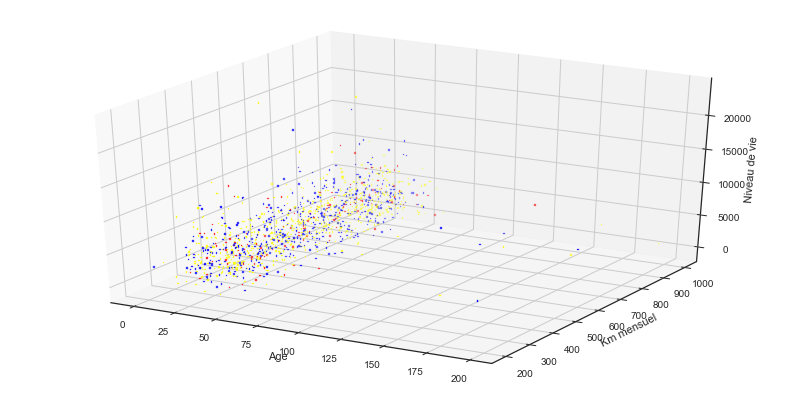

In [23]:
from mpl_toolkits.mplot3d import Axes3D
sample=data.sample(n=1300)
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111, projection='3d')
colormap = np.array(['blue','yellow','red', 'lime', 'orange'])
ax.scatter(sample['Age'],sample['Kilometres parcourus par mois'],sample['Niveau de vie'],color=colormap[model.labels_],
           marker=',',depthshade=True,s=2)

ax.set_xlabel('Age')
ax.set_ylabel('Km mensuel')
ax.set_zlabel('Niveau de vie')

plt.show()

***Au vu des clusters résultant, les résultats ne semblent pas suffisamment concluants pour les trois axes que nous avons choisis.Néanmoins on constate déjà à vu d'oeil des outliers concernant l'âge. ***

In [24]:
#Cette commande nous permet de charger la variable data, et de la stocker pour l'exploiter dans un autre Notebook.
%store data

Stored 'data' (DataFrame)
